# Self-Driving Car Engineer Nanodegree


## Project: **Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

### Helper Functions


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import scipy.signal as signal
#matplotlib inline

def calibrateCamera(fpath, nx, ny, manualCheck = False):
    # Read in a calibration image
    img = mpimg.imread(fpath)

    # Arrays to store object points and image points from all the images
    objpoints = [] # 3D points in read word space
    imgpoints = [] # 2D points in image plane

    # Prepare object points, like (0, 0, 0), (1, 0, 0), (2, 0, 0), ..., (7, 5, 0)
    objp = np.zeros((ny*nx, 3), np.float32)
    objp[:,:2] = np.mgrid[0:nx, 0:ny].T.reshape(-1, 2) # x, y coordinate

    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
    
        # draw and display the corners
        img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    undistorted = cv2.undistort(img, mtx, dist)

    if manualCheck:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
        f.tight_layout()
        ax1.imshow(img)
        ax1.set_title('Original Image', fontsize=50)
        ax2.imshow(undistorted)
        ax2.set_title('Undistorted Image', fontsize=50)
        plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        plt.show()
    
    return mtx, dist

    
def crop_img(img, ystart=420, yend=700):
    """Returns croppped image
    """
    return img[ystart:yend, ]
    
def get_image(twoArray):
    return np.dstack((twoArray, twoArray, twoArray))
    
    
def createThresholdBinary(img, v_thresh=(170, 255), hx_thresh=(20, 80), manualCheck = False):
    img = np.copy(img)
    # Convert to HSV color space and separate the V channel
    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV).astype(np.float)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB).astype(np.float)
    
    if manualCheck:
        f, axarr = plt.subplots(3, 3, figsize=(10,10))
        axarr[0, 0].set_title('HSV h-channel')
        axarr[0, 0].imshow(get_image(hsv[:,:,0]))
        axarr[0, 1].set_title('HSV s-channel')
        axarr[0, 1].imshow(get_image(hsv[:,:,1]))
        axarr[0, 2].set_title('HSV v-channel')
        axarr[0, 2].imshow(get_image(hsv[:,:,2]))
        
        axarr[1, 0].set_title('HLS h-channel')
        axarr[1, 0].imshow(get_image(hls[:,:,0]))
        axarr[1, 1].set_title('HLS l-channel')
        axarr[1, 1].imshow(get_image(hls[:,:,1]))
        axarr[1, 2].set_title('HLS s-channel')
        axarr[1, 2].imshow(get_image(hls[:,:,2]))
        
        axarr[2, 0].set_title('LAB l-channel')
        axarr[2, 0].imshow(get_image(lab[:,:,0]))
        axarr[2, 1].set_title('LAB a-channel')
        axarr[2, 1].imshow(get_image(lab[:,:,1]))
        axarr[2, 2].set_title('LAB b-channel')
        axarr[2, 2].imshow(get_image(lab[:,:,2]))
        plt.show()
    
    v_channel = hsv[:, :, 2]
    l_channel = lab[:, :, 0]
    b_channel = lab[:, :, 2]
    
    # Sobel x for b-channel
    sobelx = cv2.Sobel(b_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= hx_thresh[0]) & (scaled_sobel <= hx_thresh[1])] = 1
    
    # Threshold color channel (vue)
    v_binary = np.zeros_like(v_channel)
    v_binary[(v_channel >= v_thresh[0]) & (v_channel <= v_thresh[1])] = 1
    
    # Threshold color channel (l-channel)
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= v_thresh[0]) & (l_channel <= v_thresh[1])] = 1
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack(( l_binary, v_binary, np.zeros_like(sxbinary)))
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(v_binary == 1) | (l_binary == 1)] = 1

    # Plotting thresholded images
    if manualCheck:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Stacked thresholds')
        ax1.imshow(color_binary)
        ax2.set_title('Combined S channel and gradient thresholds')
        ax2.imshow(combined_binary, cmap='gray')
        ax3.set_title('Orginal image')
        ax3.imshow(img)
        plt.show()

    return combined_binary, color_binary
    
def getUndistortedCroppedPerspectiveBinary(img, mtx, dist, M, manualCheck = False):
    undistorted = cv2.undistort(img, mtx, dist)
    combined_binary, color_binary = createThresholdBinary(undistorted, manualCheck = manualCheck)
    cropped = crop_img(combined_binary)
    img_shape = (cropped.shape[1], cropped.shape[0])
    warpped = cv2.warpPerspective(cropped, M, img_shape, flags=cv2.INTER_LINEAR)
    if manualCheck:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('Original')
        ax1.imshow(img)
        ax2.set_title('Cropped')
        ax2.imshow(cropped)
        ax3.set_title('Cropped and Warpped')
        ax3.imshow(warpped, cmap='gray')
        plt.show()
    return warpped;
    
def getUndistortedPerspectiveBinary(img, mtx, dist, M, manualCheck = False):
    undistorted = cv2.undistort(img, mtx, dist)
    warpped = getPerspectiveBinary(undistorted, M, manualCheck = manualCheck)
    return warpped;
    
def getPerspectiveBinary(undistorted, M, manualCheck = False):
    img_shape = (undistorted.shape[1], undistorted.shape[0])
    warpped = cv2.warpPerspective(undistorted, M, img_shape, flags=cv2.INTER_LINEAR)
    combined_binary, color_binary = createThresholdBinary(warpped, manualCheck = manualCheck)
    # warpped = cv2.warpPerspective(combined_binary, M, img_shape, flags=cv2.INTER_LINEAR)
    if manualCheck:
        f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20,10))
        ax1.set_title('undistorted')
        ax1.imshow(undistorted)
        ax2.set_title('binary')
        ax2.imshow(combined_binary)
        ax3.set_title('Warpped')
        ax3.imshow(warpped, cmap='gray')
        plt.show()
    return combined_binary;
    
    
def window_mask(width, height, img_ref, center, level):
    output = np.zeros_like(img_ref)
    output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return output
    
def find_window_centroids(warped, window_width, window_height, margin):
    
    window_centroids = [] # Store the (left,right) window centroid positions per level
    window = np.ones(window_width) # Create our window template that we will use for convolutions
    
    # First find the two starting positions for the left and right lane by using np.sum to get the vertical image slice
    # and then np.convolve the vertical image slice with the window template 
    
    # Sum quarter bottom of image to get slice, could use a different ratio
    l_sum = np.sum(warped[int(3*warped.shape[0]/4):,:int(warped.shape[1]/2)], axis=0)
    l_center = np.argmax(np.convolve(window,l_sum))-window_width/2
    r_sum = np.sum(warped[int(3*warped.shape[0]/4):,int(warped.shape[1]/2):], axis=0)
    r_center = np.argmax(np.convolve(window,r_sum))-window_width/2+int(warped.shape[1]/2)
    
    # Add what we found for the first layer
    window_centroids.append((l_center,r_center))
    
    # Go through each layer looking for max pixel locations
    for level in range(1,(int)(warped.shape[0]/window_height)):
	    # convolve the window into the vertical slice of the image
	    image_layer = np.sum(warped[int(warped.shape[0]-(level+1)*window_height):int(warped.shape[0]-level*window_height),:], axis=0)
	    conv_signal = np.convolve(window, image_layer)
	    # Find the best left centroid by using past left center as a reference
	    # Use window_width/2 as offset because convolution signal reference is at right side of window, not center of window
	    offset = window_width/2
	    l_min_index = int(max(l_center+offset-margin,0))
	    l_max_index = int(min(l_center+offset+margin,warped.shape[1]))
	    l_center = np.argmax(conv_signal[l_min_index:l_max_index])+l_min_index-offset
	    # Find the best right centroid by using past right center as a reference
	    r_min_index = int(max(r_center+offset-margin,0))
	    r_max_index = int(min(r_center+offset+margin,warped.shape[1]))
	    r_center = np.argmax(conv_signal[r_min_index:r_max_index])+r_min_index-offset
	    # Add what we found for that layer
	    window_centroids.append((l_center,r_center))

    return window_centroids
    
def display_window(window_centroids, warped, window_width, window_height, margin):
    # If we found any window centers
    if len(window_centroids) > 0:

        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)

        # Go through each level and draw the windows 	
        for level in range(0,len(window_centroids)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(window_width,window_height,warped,window_centroids[level][0],level)
            r_mask = window_mask(window_width,window_height,warped,window_centroids[level][1],level)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255

        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        plt.imshow(warpage)
        plt.show()
        output = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
     
    # If no window centers found, just display orginal road image
    else:
        output = np.array(cv2.merge((warped,warped,warped)),np.uint8)

    # Display the final results
    plt.imshow(output)
    plt.title('window fitting results')
    plt.show()
    
def detectLanesWithoutPreFrame(binary_warped, margin = 50, nwindows = 7, minpix = 20, visualization = False):
    histogram = np.sum(binary_warped[int(binary_warped.shape[0]*3/4):,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    
    # result = signal.find_peaks_cwt(histogram, 20, min_length=100)
    # print("zzy===result: ", result)
    
    # plotx = np.linspace(0, binary_warped.shape[1]-1, binary_warped.shape[1] )
    # plt.plot(plotx, histogram, color='yellow')
    # plt.show()
    
    
    # print((leftx_base, rightx_base))
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    if visualization:
        # Generate x and y values for plotting
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        plt.imshow(out_img)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()

    return left_fit, right_fit
    
def detectLanesWithPreFram(binary_warped, margin, left_fit, right_fit, visualization = False):
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Search lanes based on previous frame ploy fit
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit_current = np.polyfit(lefty, leftx, 2)
    right_fit_current = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit_current[0]*ploty**2 + left_fit_current[1]*ploty + left_fit_current[2]
    right_fitx = right_fit_current[0]*ploty**2 + right_fit_current[1]*ploty + right_fit_current[2]    
    
    if visualization:
        # Create an image to draw on and an image to show the selection window
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        window_img = np.zeros_like(out_img)
        # Color in left and right line pixels
        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

        # Generate a polygon to illustrate the search window area
        # And recast the x and y points into usable format for cv2.fillPoly()
        left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
        left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
        left_line_pts = np.hstack((left_line_window1, left_line_window2))
        right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
        right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
        right_line_pts = np.hstack((right_line_window1, right_line_window2))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
        cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
        result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
        plt.imshow(result)
        plt.plot(left_fitx, ploty, color='yellow')
        plt.plot(right_fitx, ploty, color='yellow')
        plt.xlim(0, 1280)
        plt.ylim(720, 0)
        plt.show()
    
    return left_fit_current, right_fit_current
    
def calculateCurvature(left_fit, right_fit, y_eval = 280):
    left_curv = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curv = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    return left_curv, right_curv
    

def drawDetectedBoundary(undistorted, inverseM, left_fit, right_fit, ym_per_pix = 30/720, xm_per_pix=3.7/700):
    ploty = np.linspace(0, undistorted.shape[0]-1, undistorted.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    warpped_image = np.zeros_like(undistorted)
    left_fit_ps = np.array([np.transpose(np.vstack([left_fitx, ploty]))])    
    right_fit_ps = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((left_fit_ps, right_fit_ps))
    # fill area
    cv2.fillPoly(warpped_image, np.int_([pts]), (0, 255, 0))
    
    # fill lines
    #cv2.polylines(warpped_image, np.int_([left_fit_ps]), False, (0, 255, 0))
    #cv2.polylines(warpped_image, np.int_([right_fit_ps]), False, (255, 0, 0))
    # plt.imshow(warpped_image)
    # plt.show()
    
    # Unwarp the filled area back to original perspective
    unwarpped = cv2.warpPerspective(warpped_image, inverseM, (undistorted.shape[1], undistorted.shape[0])) 
    
    # Combine the result with undistorted image
    result = cv2.addWeighted(undistorted, 1, unwarpped, 0.3, 0)
    
    ## Put Text about off line distance and curvature
    font = cv2.FONT_HERSHEY_SIMPLEX
    off_center = round(((left_fitx[-1] + right_fitx[-1])/2 - 640) * xm_per_pix * 1000)
    str1 = str('distance from center: ' + str(off_center) + 'cm')
    cv2.putText(result, str1 , (430,630), font, 1, (0,0,255), 2, cv2.LINE_AA)
    
    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)
    
    left_curv, right_curv = calculateCurvature(left_fit_cr, right_fit_cr, np.max(ploty))
    curvature = round((left_curv + right_curv) * 0.5 / 1000, 2)
    str2 = str('radius of curvature: ' + str(curvature) + 'km')
    cv2.putText(result, str2, (430,670), font, 1, (0,0,255), 2, cv2.LINE_AA)    
    # plt.imshow(result)
    # plt.show()
    
    return result


## Section 1: Calibrate camera

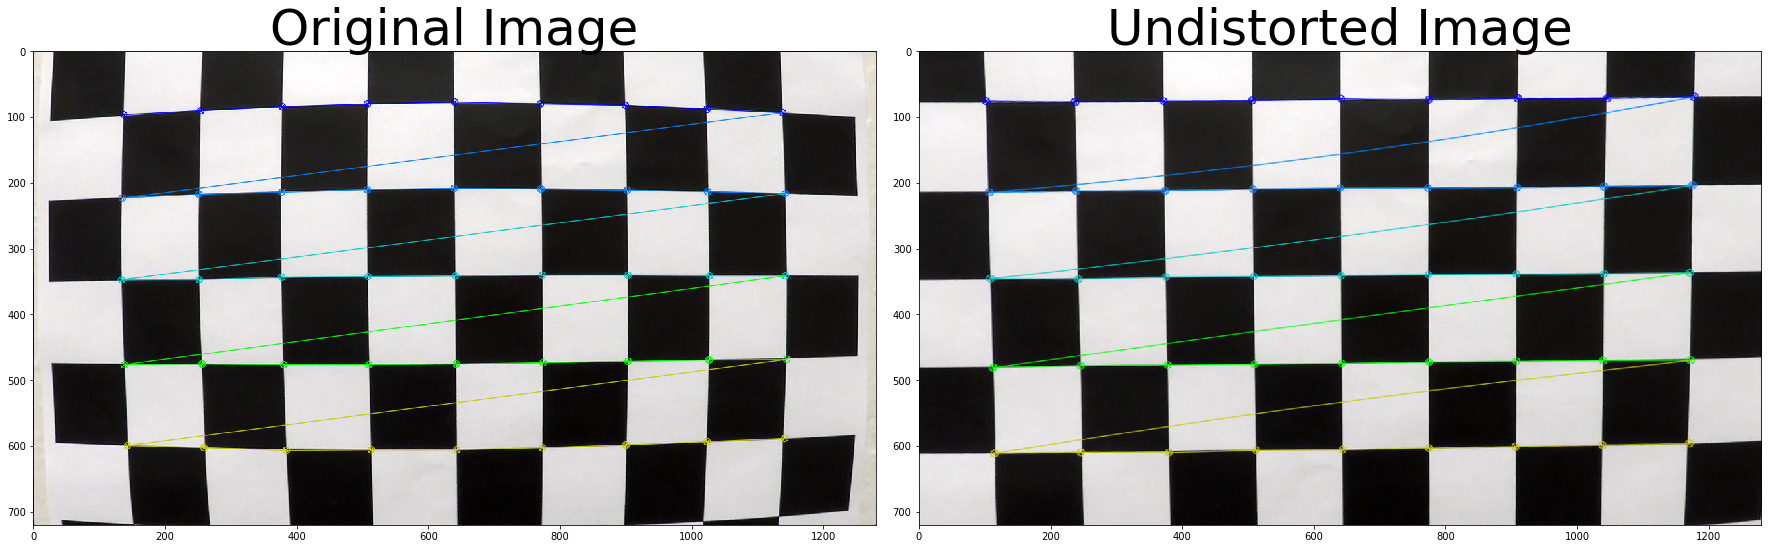

In [2]:
manualCheck = True

fpath = '.\camera_cal\calibration1.jpg'
mtx, dist = calibrateCamera(fpath, 9, 5, manualCheck = manualCheck)

## Section 2: Undistorted image

In [3]:
straight_line_image = mpimg.imread('test_images/challenge01.jpg')
undistorted = cv2.undistort(straight_line_image, mtx, dist)

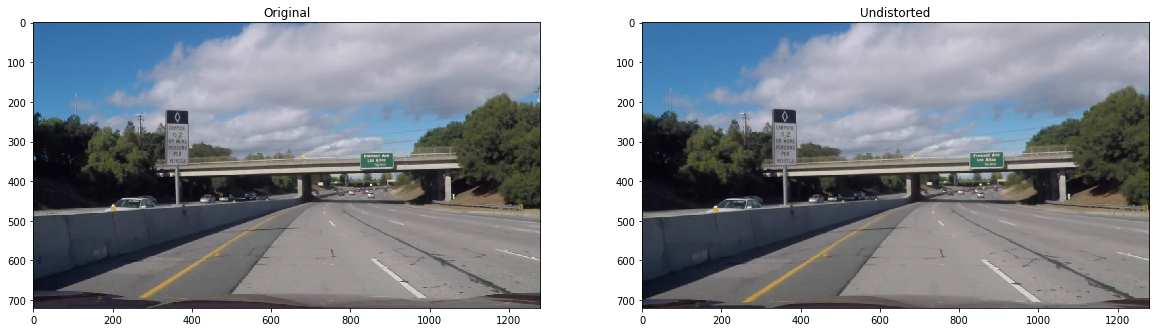

In [4]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(straight_line_image)
ax2.set_title('Undistorted')
ax2.imshow(undistorted)
plt.show()

## Section 3: Calculate perspective matrix M.

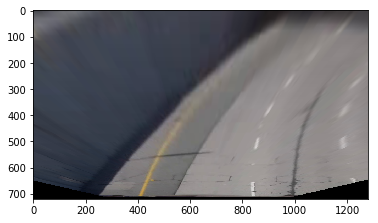

In [5]:
### Manually measured 4 points (255, 683), (1052, 683), (594, 448), (684, 448)
selected_points = np.float32([[260.041, 681.833],[1044.35, 681.833], [685.594, 450.61],[593.598, 450.61]])
# Desired 4 points, make sure the center is 640
points = np.float32([[390, 700],[890, 700],[890, 0], [390, 0]])

img_shape = (straight_line_image.shape[1], straight_line_image.shape[0])
M = cv2.getPerspectiveTransform(selected_points, points)
inverseM = cv2.getPerspectiveTransform(points, selected_points)
warpped = cv2.warpPerspective(undistorted, M, img_shape, flags=cv2.INTER_LINEAR)
if manualCheck:
    plt.imshow(warpped)
    plt.show()

## Section 4: Use color transforms, gradients, etc., to create a thresholded binary image.

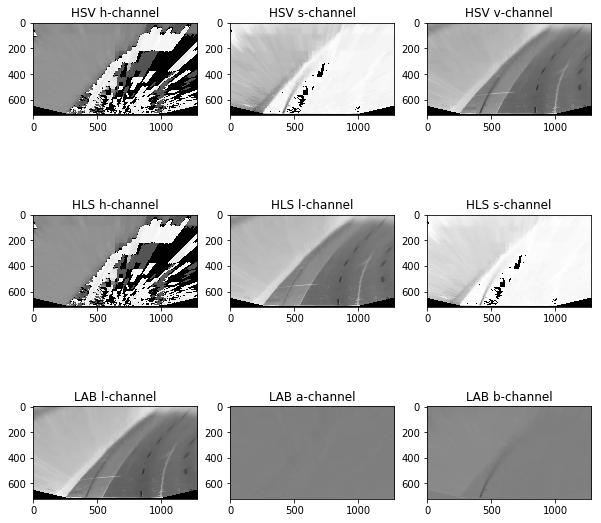

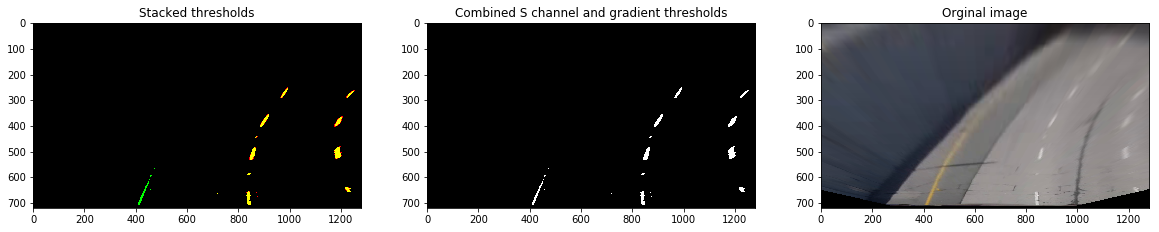

In [6]:
combined_binary, color_binary = createThresholdBinary(warpped, manualCheck = manualCheck)

## Section 5: Caculate curvature on test image

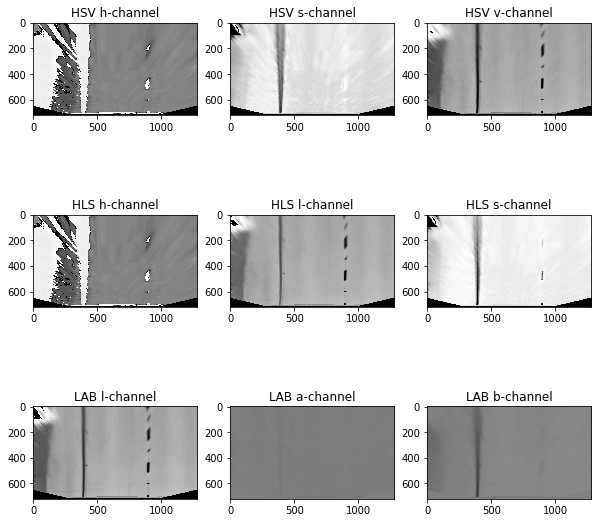

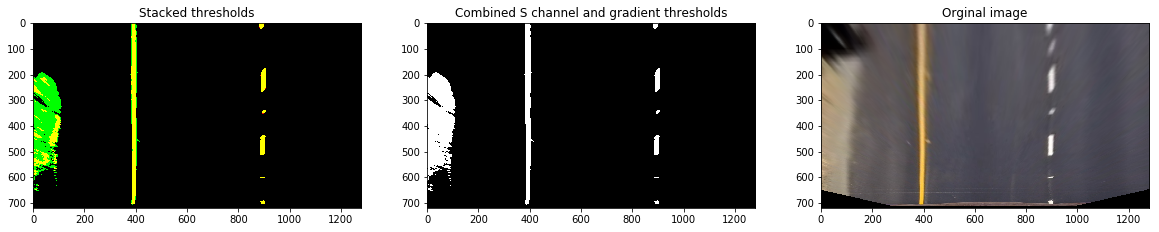

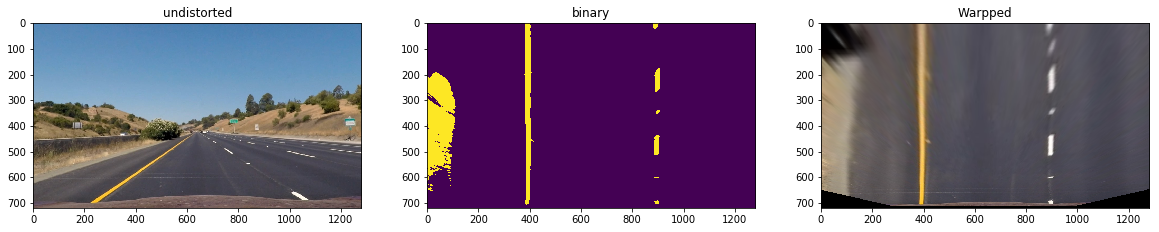

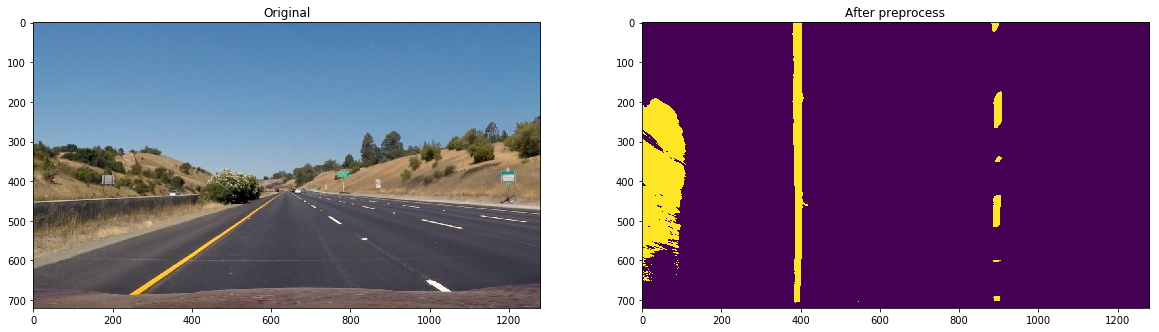

In [7]:
## Preprocess image
test_image = mpimg.imread('test_images/straight_lines1.jpg')
warpped = getUndistortedPerspectiveBinary(test_image, mtx, dist, M, manualCheck=manualCheck)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(test_image)
ax2.set_title('After preprocess')
ax2.imshow(warpped)
plt.show()

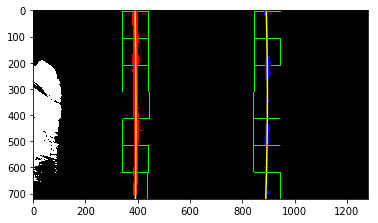

In [8]:
margin = 50 # How much to slide left and right for searching
#window_centroids = utils.find_window_centroids(warpped, window_width, window_height, margin)
#utils.display_window(window_centroids, warpped, window_width, window_height, margin)
left_fit, right_fit = detectLanesWithoutPreFrame(warpped, margin, 7, visualization = manualCheck)

## Section 6: Caculate curvature based on previous image

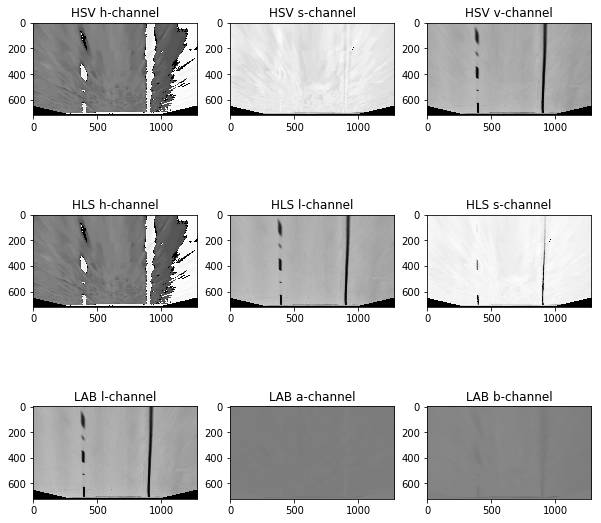

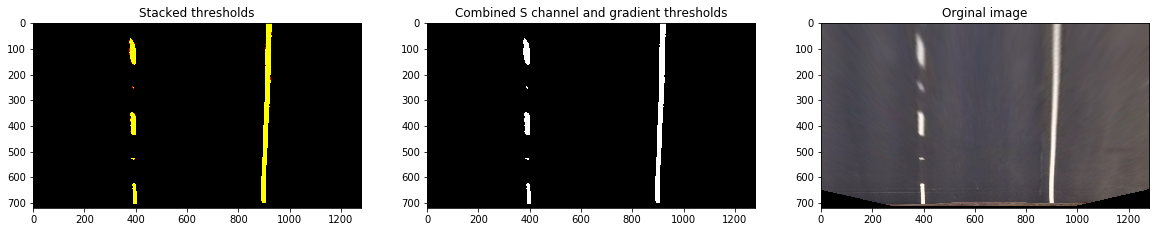

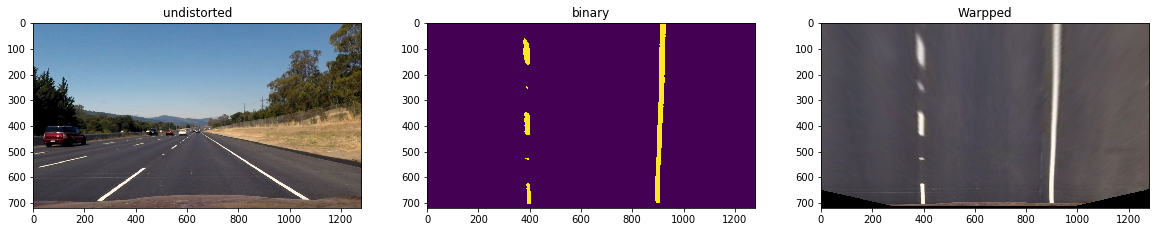

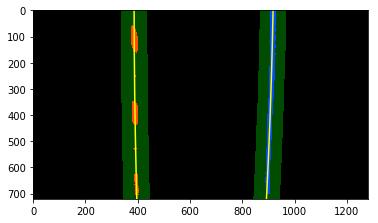

(array([  1.80182103e-05,   1.36101954e-03,   3.86262441e+02]),
 array([ -2.24312505e-05,  -1.87794817e-02,   9.17508113e+02]))

In [9]:
test_image = mpimg.imread('test_images/straight_lines2.jpg')
warpped = getUndistortedPerspectiveBinary(test_image, mtx, dist, M, manualCheck=manualCheck)
detectLanesWithPreFram(warpped, margin, left_fit, right_fit, visualization = manualCheck)

## Section 7: draw curvature on orginal image

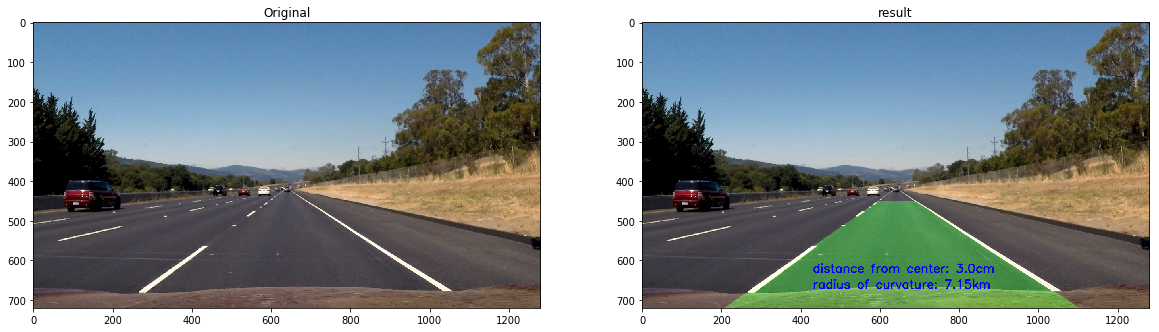

In [10]:
result = drawDetectedBoundary(test_image, inverseM, left_fit, right_fit)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.set_title('Original')
ax1.imshow(test_image)
ax2.set_title('result')
ax2.imshow(result)
plt.show()

## Section 8: Generate video.

### Process image method definition

In [11]:
### Need parameters mtx, dist, M
def process_image(img):
    global left_fit
    global right_fit

    undistorted = cv2.undistort(img, mtx, dist)
    warpped = getPerspectiveBinary(undistorted, M)
    margin = 50
    if left_fit != None and right_fit != None:
        left_fit, right_fit = detectLanesWithPreFram(warpped, 25, left_fit, right_fit)
    else:
        print("detectLanesWithoutPreFrame is executed")
        left_fit, right_fit = detectLanesWithoutPreFrame(warpped, margin, 7, visualization = manualCheck)

    # Warp the detected lane boundaries and draw back onto the original image.
    return drawDetectedBoundary(undistorted, inverseM, left_fit, right_fit)

In [12]:
manualCheck = False

In [13]:
# Step 7: Generate video
from moviepy.editor import VideoFileClip

left_fit = None
right_fit = None
white_output = 'project_video_output.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
# clip1 = VideoFileClip("challenge_video.mp4")
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)


detectLanesWithoutPreFrame is executed
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████▉| 1260/1261 [03:27<00:00,  6.25it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 



In [14]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Section 9: Chanllenge Video

In [15]:
left_fit = None
right_fit = None
white_output = 'challenge_video_output.mp4'
# To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,2)
clip1 = VideoFileClip("challenge_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
# %time white_clip.write_videofile(white_output, audio=False)
white_clip.write_videofile(white_output, audio=False)

detectLanesWithoutPreFrame is executed
[MoviePy] >>>> Building video challenge_video_output.mp4
[MoviePy] Writing video challenge_video_output.mp4


100%|████████████████████████████████████████| 485/485 [01:19<00:00,  6.30it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: challenge_video_output.mp4 



In [16]:
from IPython.display import HTML

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))